In [1]:
from importlib import reload
import sys
import os
sys.path.append(os.path.abspath('../'))
import util
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [48]:
kelphodl = util.load_data(0,'TEST')
kelphodl = kelphodl[kelphodl['product'] == 'KELP']
kelphodl.set_index('timestamp', inplace=True)
kelphodl.index = kelphodl.index/100

In [47]:
kelp_raw = util.load_data(0,-1)
kelp_raw = kelp_raw[kelp_raw['product'] == 'KELP']
kelp_raw.set_index('timestamp', inplace=True)
kelp_raw.index = kelp_raw.index/100

In [31]:

same = (kelp_raw.drop(columns=['profit_and_loss']).fillna(0) == kelphodl.drop(columns=['profit_and_loss']).fillna(0)).sum(1).sum()/(len(kelp_raw)*(len(kelp_raw.columns)-1)) == 1
p = print
p('HODL and raw order are the same:', same)

HODL and raw order are the same: True


Theory last year was that there was always a market maker that submitted big ask and bid orders from sizes 20-30. Using the mid price they claimed to have captured the true fair, backed by buying and holding one and comparing the pnl between timestamps.

Here, we see an example of a timestamp where only a large bid is in the orderbook. This happens a few time. Using the market makers mid or volume weighted mid is unreliable and has a few outliers.

In [36]:
kelphodl.loc[579:580]

,day,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
timestamp,,,,,,,,,,,,,,,,
579.0,-1,KELP,2017,27,NaN,NaN,NaN,NaN,2018,6,2019.0,5.0,2020.0,2.0,2017.5,-10.188354
580.0,-1,KELP,2017,29,NaN,NaN,NaN,NaN,2020,1,2021.0,24.0,NaN,NaN,2018.5,-10.202148


In [99]:
kelphodl.loc[1302:1303]

,day,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
timestamp,,,,,,,,,,,,,,,,
1302.0,-1,KELP,2013,23,NaN,NaN,NaN,NaN,2014,3,2015.0,3.0,2016.0,2.0,2013.5,-14.150146
1303.0,-1,KELP,2013,26,NaN,NaN,NaN,NaN,2017,26,NaN,NaN,NaN,NaN,2015.0,-13.960815


Furthermore, the true mid is often masked by some noise from other bots submitting the same ask/bid as the large market maker. Example of that can be seen here, where the change in PNL is -0.6, very large, but the orderbook barely changed in terms of weighting on both sides.

In [42]:
kelphodl.iloc[7:9]

,day,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
timestamp,,,,,,,,,,,,,,,,
7.0,-1,KELP,2025,2,2024.0,23.0,NaN,NaN,2028,23,NaN,NaN,NaN,NaN,2026.5,-3.140869
8.0,-1,KELP,2024,1,2023.0,29.0,NaN,NaN,2027,30,NaN,NaN,NaN,NaN,2025.5,-3.789917


Using VWAP seems to be a lot more stable. The max deviation from the true fair is around 0.25. Outliers are some when theres only a large volume on one side or the orderbook.

<Axes: title={'center': 'KELP VWAP and PnL'}, xlabel='timestamp'>

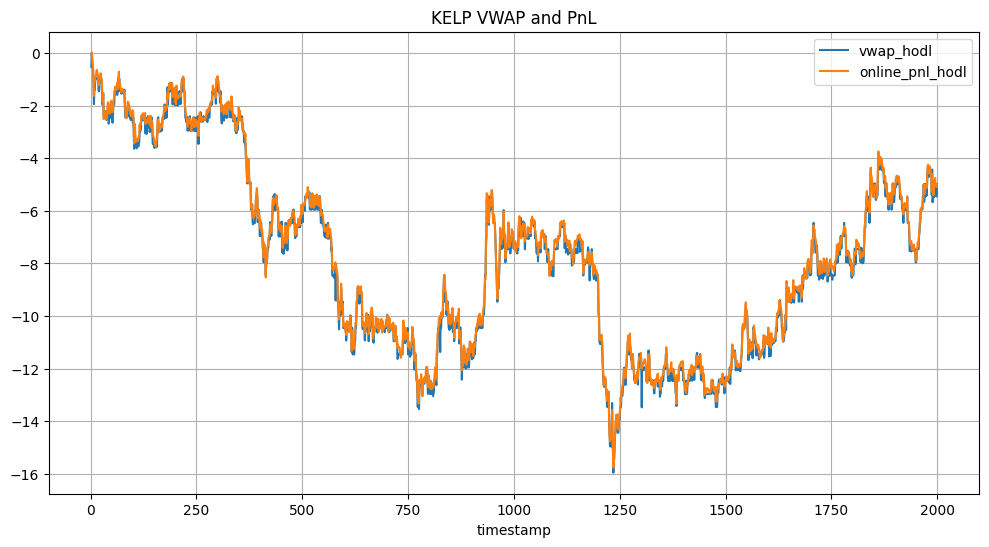

In [89]:
kelp_vwap = util.get_vwap(kelp_raw,0)
pd.DataFrame(np.array([kelp_vwap.diff().loc[2:].cumsum(), kelphodl['profit_and_loss'].diff().loc[2:].cumsum()]).T, columns=['vwap_hodl', 'online_pnl_hodl'], index=kelp_raw.index[2:]).plot(title='KELP VWAP and PnL', figsize=(12, 6), grid=True)

<Axes: title={'center': 'KELP VWAP and PnL'}, xlabel='timestamp'>

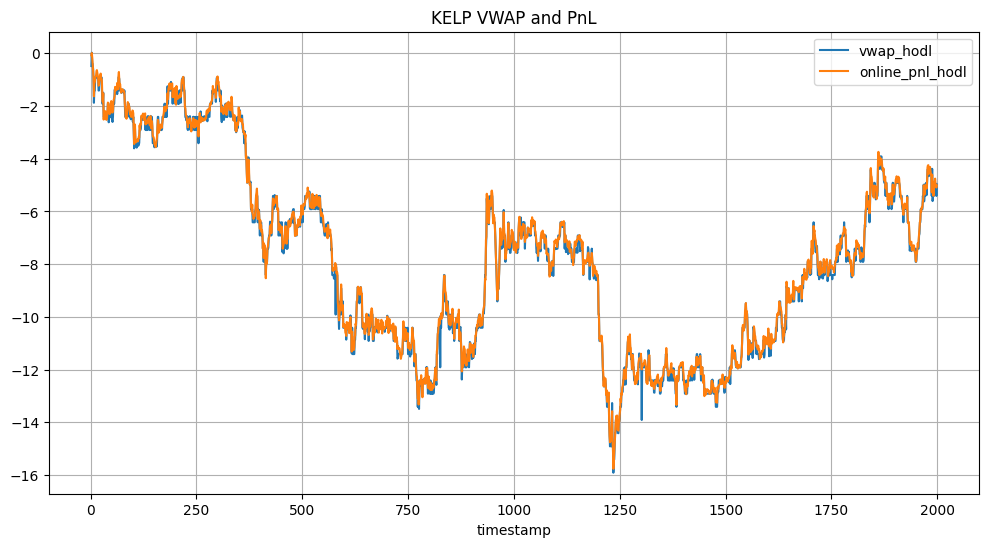

In [100]:
reload(util)
kelp_vwap = util.get_vwap(kelp_raw,13)
pd.DataFrame(np.array([kelp_vwap.diff().loc[2:].cumsum(), kelphodl['profit_and_loss'].diff().loc[2:].cumsum()]).T, columns=['vwap_hodl', 'online_pnl_hodl'], index=kelp_raw.index[2:]).plot(title='KELP VWAP and PnL', figsize=(12, 6), grid=True)

Text(0.5, 1.0, 'VWAP - True Fair + Constant')

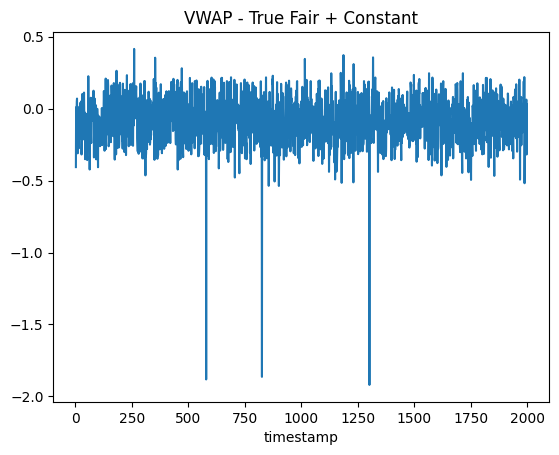

In [101]:
price_diff = (kelp_vwap.diff().loc[2:].cumsum()-kelphodl['profit_and_loss'].diff().loc[2:].cumsum())
price_diff.plot()
plt.title('VWAP - True Fair + Constant')
# Outliers are when theres a large volume on only one side of the book

In [98]:
price_diff.sort_values().head(10)

timestamp
1302.0   -1.481787
579.0    -1.377450
826.0    -1.319762
1989.0   -0.586372
1179.0   -0.583780
901.0    -0.582479
1231.0   -0.557503
882.0    -0.551281
1752.0   -0.540282
1969.0   -0.538277
dtype: float64